In [ ]:

from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/drone /content/drone
print("Dataset copied to Colab local storage")

dataset_path = "/content/drone"


Mounted at /content/drive
Dataset copied to Colab local storage


In [ ]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

print("CNN for 7 RPM Classes")
print(f"TensorFlow version: {tf.__version__}")


CNN for 7 RPM Classes
TensorFlow version: 2.19.0


In [ ]:
def load_multi_rpm_dataset(base_path, rpm_values=[100, 200, 300, 400, 500, 600, 700]):
    signals = []
    labels = []

    for rpm in rpm_values:
        rpm_folder = os.path.join(base_path, f'RPM_{rpm:04d}', 'drone_signal')

        if os.path.exists(rpm_folder):
            sample_files = glob.glob(os.path.join(rpm_folder, 'drone_signal_sample_*.mat'))
            sample_files.sort()

            print(f"Found {len(sample_files)} samples for RPM {rpm}")

            for sample_file in sample_files:
                try:
                    mat_data = scipy.io.loadmat(sample_file)

                    if 'drone_signal' in mat_data:
                        signal_data = mat_data['drone_signal']

                        if signal_data.ndim > 1:
                            signal_data = signal_data.flatten()

                        if len(signal_data) < 1000 or len(signal_data) > 100000:
                            continue

                        signals.append(signal_data)
                        labels.append(rpm)

                except Exception as e:
                    continue

    return signals, labels


In [ ]:
signals, labels = load_multi_rpm_dataset(dataset_path)

print(f"\nDataset Summary:")
print(f"Total samples: {len(signals)}")

for rpm in [100, 200, 300, 400, 500, 600, 700]:
    count = labels.count(rpm)
    print(f"RPM {rpm}: {count} samples")


Found 151 samples for RPM 100
Found 150 samples for RPM 200
Found 150 samples for RPM 300
Found 150 samples for RPM 400
Found 150 samples for RPM 500
Found 150 samples for RPM 600
Found 150 samples for RPM 700

Dataset Summary:
Total samples: 1051
RPM 100: 151 samples
RPM 200: 150 samples
RPM 300: 150 samples
RPM 400: 150 samples
RPM 500: 150 samples
RPM 600: 150 samples
RPM 700: 150 samples


In [ ]:
def preprocess_with_augmentation(signals, target_length=4000):
    print(f"\nPreprocessing with augmentation")

    processed_signals = []
    augmented_signals = []
    augmented_labels = []

    for i, signal in enumerate(signals):
        if np.iscomplexobj(signal):
            magnitude = np.abs(signal)
            phase = np.angle(signal)

            if len(magnitude) > target_length:
                indices = np.linspace(0, len(magnitude) - 1, target_length, dtype=int)
                magnitude = magnitude[indices]
                phase = phase[indices]
            elif len(magnitude) < target_length:
                magnitude = np.pad(magnitude, (0, target_length - len(magnitude)), mode='reflect')
                phase = np.pad(phase, (0, target_length - len(phase)), mode='reflect')

            inst_freq = np.gradient(np.unwrap(phase))
            features = np.stack([magnitude, phase, inst_freq], axis=-1)
        else:
            if len(signal) > target_length:
                indices = np.linspace(0, len(signal) - 1, target_length, dtype=int)
                signal = signal[indices]
            elif len(signal) < target_length:
                signal = np.pad(signal, (0, target_length - len(signal)), mode='reflect')

            derivative = np.gradient(signal)
            energy = np.convolve(signal**2, np.ones(20)/20, mode='same')
            features = np.stack([signal, derivative, energy], axis=-1)

        processed_signals.append(features.astype(np.float32))

        rpm_label = labels[i]

        noise_factor = 0.003
        noisy_features = features + noise_factor * np.random.normal(0, 1, features.shape)
        augmented_signals.append(noisy_features.astype(np.float32))
        augmented_labels.append(rpm_label)

        if i % 2 == 0:
            shift = np.random.randint(-20, 21)
            shifted_features = np.roll(features, shift, axis=0)
            augmented_signals.append(shifted_features.astype(np.float32))
            augmented_labels.append(rpm_label)

        if i % 4 == 0:
            scale_factor = np.random.uniform(0.95, 1.05)
            scaled_features = features * scale_factor
            augmented_signals.append(scaled_features.astype(np.float32))
            augmented_labels.append(rpm_label)

    all_signals = processed_signals + augmented_signals
    all_labels = labels + augmented_labels

    print(f"Original samples: {len(processed_signals)}")
    print(f"Augmented samples: {len(augmented_signals)}")
    print(f"Total samples: {len(all_signals)}")

    return np.array(all_signals), np.array(all_labels)


In [ ]:
X, y = preprocess_with_augmentation(signals, target_length=4000)
print(f"\nData shape: {X.shape}")



Preprocessing with augmentation
Original samples: 1051
Augmented samples: 1840
Total samples: 2891

Data shape: (2891, 4000, 3)


In [ ]:
print("Normalizing data...")

X_normalized = np.zeros_like(X)
scalers = []

for channel in range(X.shape[2]):
    scaler = RobustScaler()
    X_channel = X[:, :, channel].reshape(X.shape[0], -1)
    X_channel_normalized = scaler.fit_transform(X_channel)
    X_normalized[:, :, channel] = X_channel_normalized.reshape(X.shape[0], X.shape[1])
    scalers.append(scaler)

X_final = X_normalized

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))

class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights))

y_categorical = keras.utils.to_categorical(y_encoded, num_classes)


Normalizing data...


In [ ]:
print("Splitting dataset...")

X_temp, X_test, y_temp, y_test = train_test_split(
    X_final, y_categorical, test_size=0.15, random_state=42, stratify=y_encoded
)

y_temp_encoded = np.argmax(y_temp, axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp_encoded
)

print(f"Training samples: {X_train.shape[0]} ({X_train.shape[0]/len(X_final)*100:.1f}%)")
print(f"Validation samples: {X_val.shape[0]} ({X_val.shape[0]/len(X_final)*100:.1f}%)")
print(f"Test samples: {X_test.shape[0]} ({X_test.shape[0]/len(X_final)*100:.1f}%)")


Splitting dataset...
Training samples: 2088 (72.2%)
Validation samples: 369 (12.8%)
Test samples: 434 (15.0%)


In [ ]:
def create_cnn_model(input_shape, num_classes):
    print(f"\nBuilding CNN model")

    model = keras.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv1D(filters=48, kernel_size=11, activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(filters=96, kernel_size=7, activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.35),
        layers.MaxPooling1D(pool_size=2),

        layers.Conv1D(filters=160, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.GlobalAveragePooling1D(),

        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.4),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = create_cnn_model(input_shape, num_classes)



Building CNN model


In [ ]:
optimizer = keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    clipnorm=0.5
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

print("\nModel Architecture:")
model.summary()
print(f"\nModel Parameters: {model.count_params():,}")

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.002,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.4,
        patience=8,
        min_lr=1e-7,
        verbose=1,
        cooldown=3
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='/content/best_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]



Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4000, 48)       │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4000, 48)       │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4000, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2000, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2000, 96)       │        32,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2000, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2000, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1000, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1000, 128)      │        61,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 500, 160)       │        61,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 500, 160)       │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500, 160)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 160)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 243,239 (950.15 KB)

 Trainable params: 241,607 (943.78 KB)

 Non-trainable params: 1,632 (6.38 KB)


Model Parameters: 243,239


In [ ]:
print(f"\nStarting training...")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1,
    shuffle=True
)



Starting training...
Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.1489 - loss: 7.7415 - top_k_categorical_accuracy: 0.7274
Epoch 1: val_accuracy improved from -inf to 0.23035, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - accuracy: 0.1492 - loss: 7.7387 - top_k_categorical_accuracy: 0.7278 - val_accuracy: 0.2304 - val_loss: 6.5818 - val_top_k_categorical_accuracy: 0.7534 - learning_rate: 5.0000e-04
Epoch 2/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2239 - loss: 6.9512 - top_k_categorical_accuracy: 0.7982
Epoch 2: val_accuracy improved from 0.23035 to 0.31436, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2259 - loss: 6.9403 - top_k_categorical_accuracy: 0.7996 - val_accuracy: 0.3144 - val_loss: 6.1191 - val_top_k_categorical_accuracy: 0.9051 - learning_rate: 5.0000e-04
Epoch 3/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3463 - loss: 6.1798 - top_k_categorical_accuracy: 0.9027
Epoch 3: val_accuracy improved from 0.31436 to 0.46883, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3479 - loss: 6.1714 - top_k_categorical_accuracy: 0.9034 - val_accuracy: 0.4688 - val_loss: 5.4928 - val_top_k_categorical_accuracy: 0.9837 - learning_rate: 5.0000e-04
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4304 - loss: 5.5423 - top_k_categorical_accuracy: 0.9484
Epoch 4: val_accuracy did not improve from 0.46883
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4308 - loss: 5.5401 - top_k_categorical_accuracy: 0.9486 - val_accuracy: 0.4661 - val_loss: 5.1534 - val_top_k_categorical_accuracy: 0.9593 - learning_rate: 5.0000e-04
Epoch 5/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4897 - loss: 5.0800 - top_k_categorical_accuracy: 0.9667
Epoch 5: val_accuracy improved from 0.46883 to 0.58537, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4908 - loss: 5.0716 - top_k_categorical_accuracy: 0.9673 - val_accuracy: 0.5854 - val_loss: 4.5130 - val_top_k_categorical_accuracy: 0.9810 - learning_rate: 5.0000e-04
Epoch 6/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5343 - loss: 4.5668 - top_k_categorical_accuracy: 0.9907
Epoch 6: val_accuracy improved from 0.58537 to 0.61518, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5348 - loss: 4.5608 - top_k_categorical_accuracy: 0.9907 - val_accuracy: 0.6152 - val_loss: 4.0431 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 7/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5784 - loss: 4.0695 - top_k_categorical_accuracy: 0.9923
Epoch 7: val_accuracy improved from 0.61518 to 0.65854, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5783 - loss: 4.0658 - top_k_categorical_accuracy: 0.9923 - val_accuracy: 0.6585 - val_loss: 3.6382 - val_top_k_categorical_accuracy: 0.9946 - learning_rate: 5.0000e-04
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5883 - loss: 3.6716 - top_k_categorical_accuracy: 0.9955
Epoch 8: val_accuracy did not improve from 0.65854
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5885 - loss: 3.6703 - top_k_categorical_accuracy: 0.9955 - val_accuracy: 0.6341 - val_loss: 3.3107 - val_top_k_categorical_accuracy: 0.9892 - learning_rate: 5.0000e-04
Epoch 9/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6140 - loss: 3.3071 - top_k_categorical_accuracy: 0.9931
Epoch 9: val_accuracy improved from 0.65854 to 0.69919, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6141 - loss: 3.3037 - top_k_categorical_accuracy: 0.9930 - val_accuracy: 0.6992 - val_loss: 2.9420 - val_top_k_categorical_accuracy: 0.9946 - learning_rate: 5.0000e-04
Epoch 10/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6461 - loss: 3.0095 - top_k_categorical_accuracy: 0.9950
Epoch 10: val_accuracy did not improve from 0.69919
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6462 - loss: 3.0047 - top_k_categorical_accuracy: 0.9951 - val_accuracy: 0.6938 - val_loss: 2.6066 - val_top_k_categorical_accuracy: 0.9946 - learning_rate: 5.0000e-04
Epoch 11/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6673 - loss: 2.6917 - top_k_categorical_accuracy: 0.9965
Epoch 11: val_accuracy improved from 0.69919 to 0.71545, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6676 - loss: 2.6876 - top_k_categorical_accuracy: 0.9965 - val_accuracy: 0.7154 - val_loss: 2.4012 - val_top_k_categorical_accuracy: 0.9946 - learning_rate: 5.0000e-04
Epoch 12/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6787 - loss: 2.3978 - top_k_categorical_accuracy: 0.9981
Epoch 12: val_accuracy did not improve from 0.71545
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6791 - loss: 2.3953 - top_k_categorical_accuracy: 0.9980 - val_accuracy: 0.6775 - val_loss: 2.1576 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 13/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7097 - loss: 2.1862 - top_k_categorical_accuracy: 0.9986
Epoch 13: val_accuracy did not improve from 0.71545
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7097 - loss: 2.1854 - top_k_categorical_accuracy: 0.9986 - val_accuracy: 0.6856 - val_loss: 1.9758 - val_top_k_categorical_accuracy: 1.0000 - learning

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7408 - loss: 1.9414 - top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.7371 - val_loss: 1.7615 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 15/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7426 - loss: 1.7989 - top_k_categorical_accuracy: 0.9973
Epoch 15: val_accuracy did not improve from 0.73713
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7424 - loss: 1.7970 - top_k_categorical_accuracy: 0.9974 - val_accuracy: 0.7263 - val_loss: 1.6320 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 16/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7533 - loss: 1.6361 - top_k_categorical_accuracy: 0.9994
Epoch 16: val_accuracy improved from 0.73713 to 0.76965, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7535 - loss: 1.6344 - top_k_categorical_accuracy: 0.9994 - val_accuracy: 0.7696 - val_loss: 1.4653 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 17/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7609 - loss: 1.5015 - top_k_categorical_accuracy: 0.9997
Epoch 17: val_accuracy did not improve from 0.76965
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7612 - loss: 1.4997 - top_k_categorical_accuracy: 0.9996 - val_accuracy: 0.7615 - val_loss: 1.3618 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 18/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7738 - loss: 1.3781 - top_k_categorical_accuracy: 0.9999
Epoch 18: val_accuracy did not improve from 0.76965
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7739 - loss: 1.3778 - top_k_categorical_accuracy: 0.9998 - val_accuracy: 0.7696 - val_loss: 1.2933 - val_top_k_categorical_accuracy: 1.0000 - learning

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7992 - loss: 1.2943 - top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.7995 - val_loss: 1.1792 - val_top_k_categorical_accuracy: 0.9946 - learning_rate: 5.0000e-04
Epoch 20/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8063 - loss: 1.1944 - top_k_categorical_accuracy: 0.9989
Epoch 20: val_accuracy did not improve from 0.79946
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8061 - loss: 1.1943 - top_k_categorical_accuracy: 0.9989 - val_accuracy: 0.7778 - val_loss: 1.1669 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 21/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8253 - loss: 1.1060 - top_k_categorical_accuracy: 1.0000
Epoch 21: val_accuracy did not improve from 0.79946
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8252 - loss: 1.1059 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.7832 - val_loss: 1.1458 - val_top_k_categorical_accuracy: 1.0000 - learning

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8333 - loss: 1.0268 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8022 - val_loss: 1.0377 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 23/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8423 - loss: 0.9905 - top_k_categorical_accuracy: 1.0000
Epoch 23: val_accuracy improved from 0.80217 to 0.80488, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8422 - loss: 0.9899 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8049 - val_loss: 0.9856 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 24/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8652 - loss: 0.9144 - top_k_categorical_accuracy: 1.0000
Epoch 24: val_accuracy improved from 0.80488 to 0.80759, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8650 - loss: 0.9143 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8076 - val_loss: 1.0002 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 25/100
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8683 - loss: 0.8592 - top_k_categorical_accuracy: 0.9997
Epoch 25: val_accuracy improved from 0.80759 to 0.85095, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8679 - loss: 0.8596 - top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.8509 - val_loss: 0.8511 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 26/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8580 - loss: 0.8503 - top_k_categorical_accuracy: 0.9988
Epoch 26: val_accuracy did not improve from 0.85095
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8585 - loss: 0.8494 - top_k_categorical_accuracy: 0.9987 - val_accuracy: 0.8482 - val_loss: 0.8368 - val_top_k_categorical_accuracy: 0.9973 - learning_rate: 5.0000e-04
Epoch 27/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8848 - loss: 0.7895 - top_k_categorical_accuracy: 0.9997
Epoch 27: val_accuracy improved from 0.85095 to 0.86179, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8847 - loss: 0.7894 - top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.8618 - val_loss: 0.7857 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 28/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8770 - loss: 0.7925 - top_k_categorical_accuracy: 0.9991
Epoch 28: val_accuracy did not improve from 0.86179
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8767 - loss: 0.7921 - top_k_categorical_accuracy: 0.9991 - val_accuracy: 0.8537 - val_loss: 0.7717 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 29/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8952 - loss: 0.7244 - top_k_categorical_accuracy: 1.0000
Epoch 29: val_accuracy improved from 0.86179 to 0.86450, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8951 - loss: 0.7238 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8645 - val_loss: 0.8529 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 30/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8961 - loss: 0.6730 - top_k_categorical_accuracy: 0.9997
Epoch 30: val_accuracy did not improve from 0.86450
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8961 - loss: 0.6733 - top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.8401 - val_loss: 0.7555 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 31/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9059 - loss: 0.6490 - top_k_categorical_accuracy: 1.0000
Epoch 31: val_accuracy did not improve from 0.86450
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9057 - loss: 0.6491 - top_k_categorical_accuracy: 0.9999 - val_accuracy: 0.8455 - val_loss: 0.7789 - val_top_k_categorical_accuracy: 0.9973 - learning

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9248 - loss: 0.5754 - top_k_categorical_accuracy: 0.9994 - val_accuracy: 0.8808 - val_loss: 0.6618 - val_top_k_categorical_accuracy: 0.9973 - learning_rate: 5.0000e-04
Epoch 35/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9299 - loss: 0.5506 - top_k_categorical_accuracy: 0.9994
Epoch 35: val_accuracy improved from 0.88076 to 0.88889, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9293 - loss: 0.5514 - top_k_categorical_accuracy: 0.9994 - val_accuracy: 0.8889 - val_loss: 0.6636 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 36/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9354 - loss: 0.5200 - top_k_categorical_accuracy: 1.0000
Epoch 36: val_accuracy did not improve from 0.88889
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9353 - loss: 0.5201 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8564 - val_loss: 0.7678 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 37/100
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9350 - loss: 0.5144 - top_k_categorical_accuracy: 1.0000
Epoch 37: val_accuracy did not improve from 0.88889
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9347 - loss: 0.5148 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8482 - val_loss: 0.7777 - val_top_k_categorical_accuracy: 1.0000 - learning

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9435 - loss: 0.4794 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8970 - val_loss: 0.6101 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 39/100
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9355 - loss: 0.4801 - top_k_categorical_accuracy: 1.0000
Epoch 39: val_accuracy did not improve from 0.89702
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9354 - loss: 0.4806 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8970 - val_loss: 0.5965 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 40/100
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9360 - loss: 0.4882 - top_k_categorical_accuracy: 1.0000
Epoch 40: val_accuracy did not improve from 0.89702
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9359 - loss: 0.4884 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8780 - val_loss: 0.6779 - val_top_k_categorical_accuracy: 1.0000 - learning

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9458 - loss: 0.4663 - top_k_categorical_accuracy: 0.9984 - val_accuracy: 0.9051 - val_loss: 0.7000 - val_top_k_categorical_accuracy: 0.9973 - learning_rate: 5.0000e-04
Epoch 42/100
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9611 - loss: 0.4122 - top_k_categorical_accuracy: 1.0000
Epoch 42: val_accuracy did not improve from 0.90515
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9609 - loss: 0.4126 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8889 - val_loss: 0.5874 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 43/100
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9461 - loss: 0.4534 - top_k_categorical_accuracy: 1.0000
Epoch 43: val_accuracy did not improve from 0.90515
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9460 - loss: 0.4533 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9024 - val_loss: 0.5924 - val_top_k_categorical_accuracy: 0.9973 - learning

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9467 - loss: 0.4428 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9241 - val_loss: 0.5198 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 45/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9642 - loss: 0.3990 - top_k_categorical_accuracy: 0.9994
Epoch 45: val_accuracy did not improve from 0.92412
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9641 - loss: 0.3991 - top_k_categorical_accuracy: 0.9994 - val_accuracy: 0.8970 - val_loss: 0.6501 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 46/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9501 - loss: 0.4060 - top_k_categorical_accuracy: 1.0000
Epoch 46: val_accuracy did not improve from 0.92412
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9498 - loss: 0.4070 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8970 - val_loss: 0.5032 - val_top_k_categorical_accuracy: 1.0000 - learning

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9819 - loss: 0.2980 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9295 - val_loss: 0.4175 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0000e-04
Epoch 56/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9912 - loss: 0.2529 - top_k_categorical_accuracy: 1.0000
Epoch 56: val_accuracy improved from 0.92954 to 0.94309, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9912 - loss: 0.2529 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9431 - val_loss: 0.3977 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0000e-04
Epoch 57/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9903 - loss: 0.2397 - top_k_categorical_accuracy: 1.0000
Epoch 57: val_accuracy did not improve from 0.94309
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9902 - loss: 0.2399 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9431 - val_loss: 0.4344 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0000e-04
Epoch 58/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9956 - loss: 0.2250 - top_k_categorical_accuracy: 1.0000
Epoch 58: val_accuracy did not improve from 0.94309
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9955 - loss: 0.2251 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9404 - val_loss: 0.3816 - val_top_k_categorical_accuracy: 1.0000 - learning

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9874 - loss: 0.2397 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9458 - val_loss: 0.3732 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0000e-04
Epoch 60/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9956 - loss: 0.2067 - top_k_categorical_accuracy: 1.0000
Epoch 60: val_accuracy did not improve from 0.94580
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9956 - loss: 0.2067 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9322 - val_loss: 0.4300 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0000e-04
Epoch 61/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9905 - loss: 0.2103 - top_k_categorical_accuracy: 1.0000
Epoch 61: val_accuracy improved from 0.94580 to 0.94851, saving model to /content/best_cnn_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9906 - loss: 0.2102 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9485 - val_loss: 0.3464 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0000e-04
Epoch 62/100
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9985 - loss: 0.1912 - top_k_categorical_accuracy: 1.0000
Epoch 62: val_accuracy did not improve from 0.94851
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9984 - loss: 0.1912 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9485 - val_loss: 0.3424 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0000e-04
Epoch 63/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9950 - loss: 0.1909 - top_k_categorical_accuracy: 1.0000
Epoch 63: val_accuracy did not improve from 0.94851
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9950 - loss: 0.1909 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9431 - val_loss: 0.3741 - val_top_k_categorical_accuracy: 1.0000 - learning

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9960 - loss: 0.1707 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9648 - val_loss: 0.3277 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0000e-04
Epoch 67/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9950 - loss: 0.1723 - top_k_categorical_accuracy: 1.0000
Epoch 67: val_accuracy did not improve from 0.96477
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9950 - loss: 0.1723 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9458 - val_loss: 0.3303 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.0000e-04
Epoch 68/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9952 - loss: 0.1649 - top_k_categorical_accuracy: 1.0000
Epoch 68: val_accuracy did not improve from 0.96477
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9952 - loss: 0.1650 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9404 - val_loss: 0.4052 - val_top_k_categorical_accuracy: 1.0000 - learning

In [ ]:
print(f"\nEvaluating model...")

test_results = model.evaluate(X_test, y_test, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_top_k = test_results[2]

y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])



Evaluating model...


In [ ]:
print(f"\n" + "="*60)
print(f"CNN TRAINING RESULTS")
print(f"="*60)

epochs_trained = len(history.history['accuracy'])
print(f"\nEpochs Trained: {epochs_trained}")

print(f"\nPerformance Metrics:")
print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Top-K Accuracy: {test_top_k:.4f} ({test_top_k*100:.2f}%)")

train_val_gap = final_train_acc - final_val_acc
val_test_gap = best_val_acc - test_accuracy

print(f"\nGeneralization Analysis:")
print(f"Train-Validation Gap: {train_val_gap:.4f} ({train_val_gap*100:.2f}%)")
print(f"Validation-Test Gap: {val_test_gap:.4f} ({val_test_gap*100:.2f}%)")

if train_val_gap < 0.03:
    status = "Excellent - Minimal overfitting"
elif train_val_gap < 0.06:
    status = "Good - Acceptable overfitting"
else:
    status = "Needs improvement - Overfitting present"

print(f"Status: {status}")

target_achieved = (final_train_acc >= 0.90 and final_val_acc >= 0.90 and test_accuracy >= 0.90)

print(f"\n90% Target Achievement:")
print(f"Training >= 90%: {'YES' if final_train_acc >= 0.90 else 'NO'} ({final_train_acc*100:.1f}%)")
print(f"Validation >= 90%: {'YES' if final_val_acc >= 0.90 else 'NO'} ({final_val_acc*100:.1f}%)")
print(f"Test >= 90%: {'YES' if test_accuracy >= 0.90 else 'NO'} ({test_accuracy*100:.1f}%)")
print(f"All Targets Met: {'SUCCESS' if target_achieved else 'PARTIAL'}")

print(f"\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes,
                          target_names=[f"RPM_{rpm}" for rpm in label_encoder.classes_]))



CNN TRAINING RESULTS

Epochs Trained: 86

Performance Metrics:
Final Training Accuracy: 0.9995 (99.95%)
Final Validation Accuracy: 0.9431 (94.31%)
Best Validation Accuracy: 0.9648 (96.48%)
Test Accuracy: 0.9171 (91.71%)
Test Top-K Accuracy: 1.0000 (100.00%)

Generalization Analysis:
Train-Validation Gap: 0.0564 (5.64%)
Validation-Test Gap: 0.0477 (4.77%)
Status: Good - Acceptable overfitting

90% Target Achievement:
Training >= 90%: YES (100.0%)
Validation >= 90%: YES (94.3%)
Test >= 90%: YES (91.7%)
All Targets Met: SUCCESS

Classification Report:
              precision    recall  f1-score   support

     RPM_100       0.98      1.00      0.99        62
     RPM_200       0.95      0.95      0.95        62
     RPM_300       0.98      0.76      0.85        62
     RPM_400       0.78      0.92      0.84        62
     RPM_500       0.89      0.92      0.90        62
     RPM_600       0.91      0.94      0.92        62
     RPM_700       0.97      0.94      0.95        62

    accura

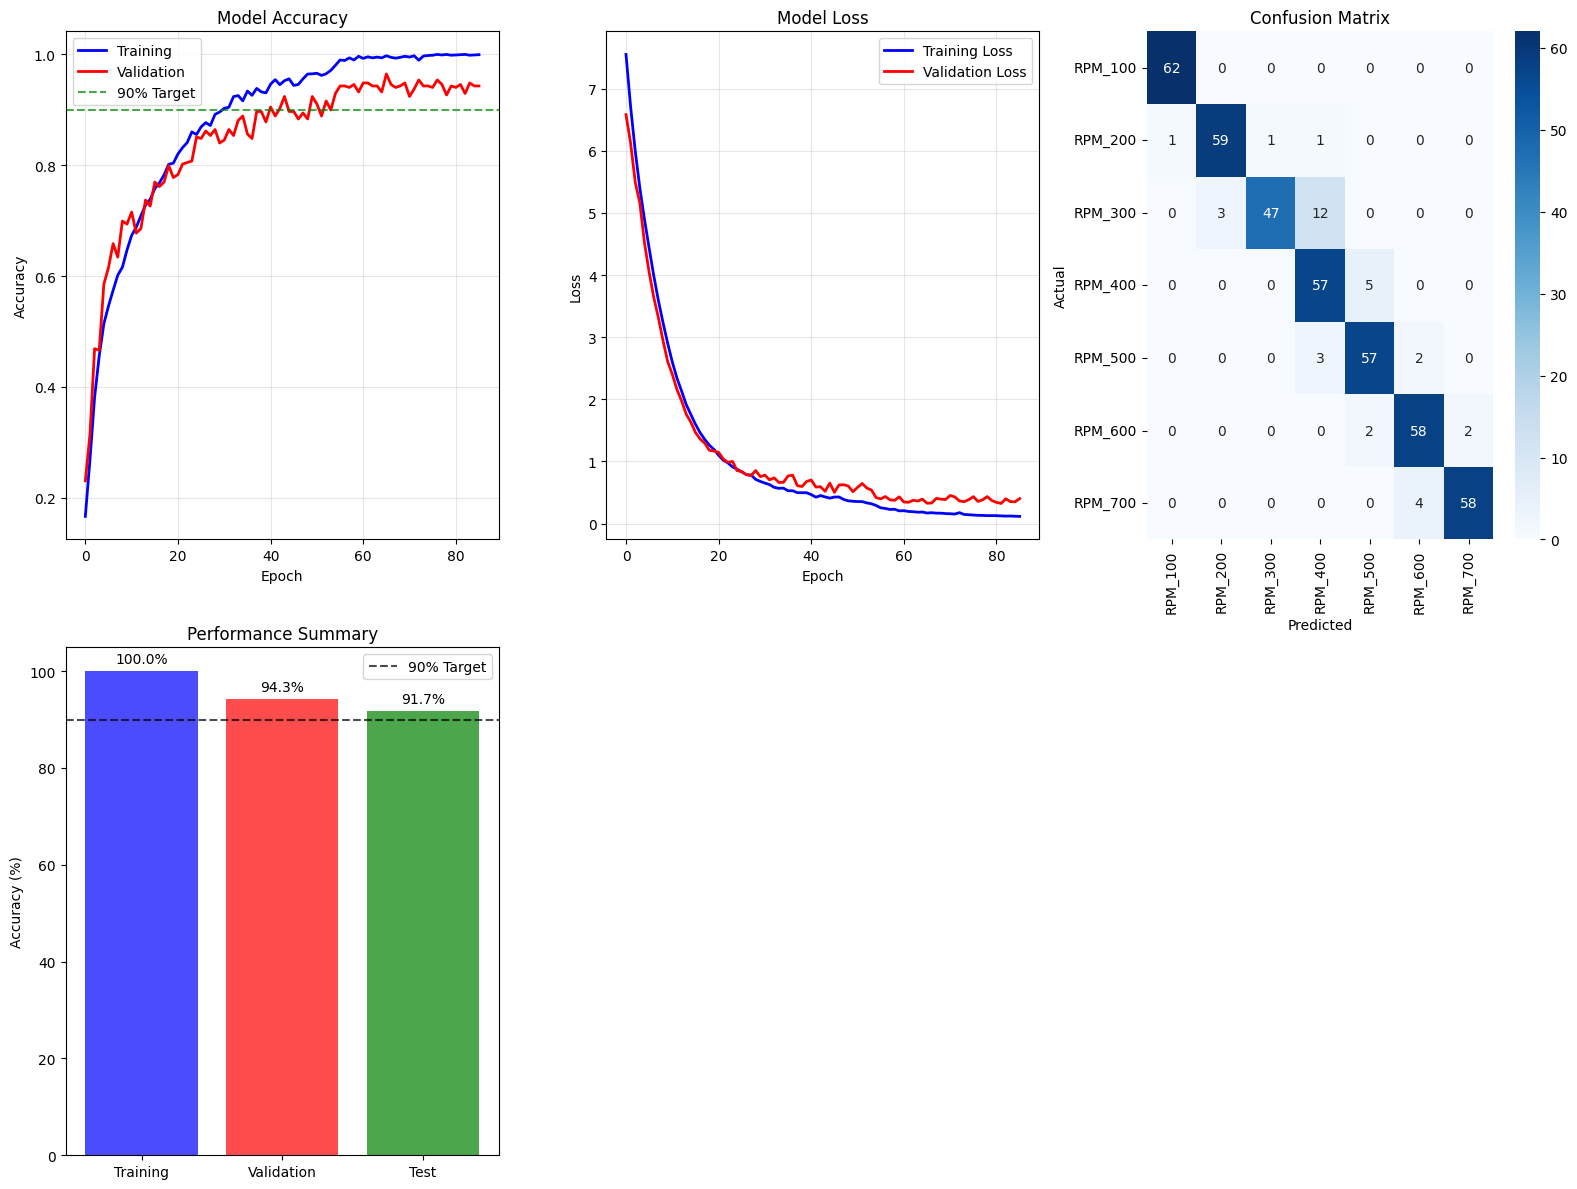


CNN Training Complete!
Final Test Accuracy: 91.7%
Overfitting Status: Good - Acceptable overfitting
Model saved as: /content/best_cnn_model.h5


In [ ]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], 'b-', linewidth=2, label='Training')
plt.plot(history.history['val_accuracy'], 'r-', linewidth=2, label='Validation')
plt.axhline(y=0.90, color='green', linestyle='--', alpha=0.7, label='90% Target')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], 'b-', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"RPM_{rpm}" for rpm in label_encoder.classes_],
            yticklabels=[f"RPM_{rpm}" for rpm in label_encoder.classes_])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 4)
metrics = ['Training', 'Validation', 'Test']
scores = [final_train_acc*100, final_val_acc*100, test_accuracy*100]
colors = ['blue', 'red', 'green']
bars = plt.bar(metrics, scores, color=colors, alpha=0.7)
plt.axhline(y=90, color='black', linestyle='--', alpha=0.7, label='90% Target')
plt.title('Performance Summary')
plt.ylabel('Accuracy (%)')
plt.legend()
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{score:.1f}%', ha='center', va='bottom')



plt.tight_layout()
plt.show()

print(f"\n" + "="*60)
print(f"CNN Training Complete!")
print(f"Final Test Accuracy: {test_accuracy*100:.1f}%")
print(f"Overfitting Status: {status}")
print(f"Model saved as: /content/best_cnn_model.h5")
print(f"="*60)


In [ ]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

OOD_CONFIG = {
    'confidence_threshold': 95.0,
    'entropy_threshold': 0.8,
    'max_prob_threshold': 0.95,
    'top2_ratio_threshold': 1.5,
    'class_separation_threshold': 0.4,  # Reduced for better OOD detection
    'stability_threshold': 0.95,
    'ood_max_prob': 0.6,  # NEW: If max prob < 60%, likely OOD
    'flat_distribution_std': 0.15  # NEW: If std < 0.15, distribution is too flat
}

def load_trained_model():
    try:
        model = keras.models.load_model('/content/best_cnn_model.h5')
        print("Model loaded successfully")
        print(f"Trained on RPM classes: {[100, 200, 300, 400, 500, 600, 700]}")
        return model
    except Exception as e:
        print(f"Error: {e}")
        return None

model = load_trained_model()
RPM_CLASSES = [100, 200, 300, 400, 500, 600, 700]
CLASS_NAMES = [f"RPM_{rpm}" for rpm in RPM_CLASSES] + ["UNKNOWN"]

def calculate_prediction_entropy(probabilities):
    epsilon = 1e-8
    probabilities = np.clip(probabilities, epsilon, 1.0)
    return -np.sum(probabilities * np.log(probabilities))

def calculate_top2_ratio(probabilities):
    sorted_probs = np.sort(probabilities)[::-1]
    return sorted_probs[0] / sorted_probs[1] if sorted_probs[1] > 0 else float('inf')

def detect_out_of_distribution(probabilities):
    """Enhanced OOD detection for untrained RPM values"""
    max_prob = np.max(probabilities)
    prob_std = np.std(probabilities)
    entropy = calculate_prediction_entropy(probabilities)

    ood_indicators = []

    # Check 1: Very low maximum probability
    if max_prob < OOD_CONFIG['ood_max_prob']:
        ood_indicators.append(f"Max probability too low: {max_prob:.3f} < {OOD_CONFIG['ood_max_prob']}")

    # Check 2: Flat probability distribution (model is confused)
    if prob_std < OOD_CONFIG['flat_distribution_std']:
        ood_indicators.append(f"Flat distribution (std={prob_std:.3f} < {OOD_CONFIG['flat_distribution_std']})")

    # Check 3: High entropy (uncertainty across all classes)
    if entropy > 1.5:  # High entropy threshold for OOD
        ood_indicators.append(f"Very high entropy: {entropy:.3f} > 1.5")

    # Check 4: Multiple classes with similar probabilities
    sorted_probs = np.sort(probabilities)[::-1]
    if len(sorted_probs) >= 3 and (sorted_probs[0] - sorted_probs[2]) < 0.2:
        ood_indicators.append(f"Top 3 classes too similar: diff={sorted_probs[0] - sorted_probs[2]:.3f}")

    is_ood = len(ood_indicators) > 0
    return is_ood, ood_indicators

def ultra_strict_validation(probabilities, features_input=None):
    max_prob = np.max(probabilities)
    confidence = max_prob * 100
    entropy = calculate_prediction_entropy(probabilities)
    top2_ratio = calculate_top2_ratio(probabilities)

    predicted_class = np.argmax(probabilities)
    predicted_rpm = RPM_CLASSES[predicted_class]

    validation_results = {
        'confidence': confidence,
        'entropy': entropy,
        'max_prob': max_prob,
        'top2_ratio': top2_ratio,
        'predicted_rpm': predicted_rpm,
        'predicted_class': predicted_class
    }

    failed_checks = []

    # First check: Out-of-distribution detection
    is_ood, ood_reasons = detect_out_of_distribution(probabilities)
    if is_ood:
        failed_checks.extend([f"OOD: {reason}" for reason in ood_reasons])

    # Regular validation checks
    if confidence < OOD_CONFIG['confidence_threshold']:
        failed_checks.append(f"Low confidence: {confidence:.1f}% < {OOD_CONFIG['confidence_threshold']}%")

    if entropy > OOD_CONFIG['entropy_threshold']:
        failed_checks.append(f"High entropy: {entropy:.2f} > {OOD_CONFIG['entropy_threshold']}")

    if max_prob < OOD_CONFIG['max_prob_threshold']:
        failed_checks.append(f"Low max probability: {max_prob:.2f} < {OOD_CONFIG['max_prob_threshold']}")

    if top2_ratio < OOD_CONFIG['top2_ratio_threshold'] and top2_ratio != float('inf'):
        failed_checks.append(f"Weak dominance: {top2_ratio:.2f} < {OOD_CONFIG['top2_ratio_threshold']}")

    if predicted_rpm == 700:
        if confidence < 98.0 or entropy > 0.5:
            failed_checks.append(f"RPM 700 special: Needs 98%+ confidence & <0.5 entropy")

    class_separation = np.sort(probabilities)[::-1][0] - np.sort(probabilities)[::-1][1]
    if class_separation < OOD_CONFIG['class_separation_threshold']:
        failed_checks.append(f"Poor separation: {class_separation:.2f} < {OOD_CONFIG['class_separation_threshold']}")

    is_unknown = len(failed_checks) > 0
    return is_unknown, failed_checks, validation_results

def preprocess_single_signal(signal, target_length=4000):
    if np.iscomplexobj(signal):
        magnitude = np.abs(signal)
        phase = np.angle(signal)

        if len(magnitude) > target_length:
            indices = np.linspace(0, len(magnitude) - 1, target_length, dtype=int)
            magnitude = magnitude[indices]
            phase = phase[indices]
        elif len(magnitude) < target_length:
            magnitude = np.pad(magnitude, (0, target_length - len(magnitude)), mode='reflect')
            phase = np.pad(phase, (0, target_length - len(phase)), mode='reflect')

        inst_freq = np.gradient(np.unwrap(phase))
        features = np.stack([magnitude, phase, inst_freq], axis=-1)
    else:
        if len(signal) > target_length:
            indices = np.linspace(0, len(signal) - 1, target_length, dtype=int)
            signal = signal[indices]
        elif len(signal) < target_length:
            signal = np.pad(signal, (0, target_length - len(signal)), mode='reflect')

        derivative = np.gradient(signal)
        energy = np.convolve(signal**2, np.ones(20)/20, mode='same')
        features = np.stack([signal, derivative, energy], axis=-1)

    return features.astype(np.float32)

def normalize_features(features):
    features_normalized = np.zeros_like(features)
    for channel in range(features.shape[-1]):
        scaler = RobustScaler()
        channel_data = features[:, channel].reshape(-1, 1)
        channel_normalized = scaler.fit_transform(channel_data)
        features_normalized[:, channel] = channel_normalized.flatten()
    return features_normalized

def make_ultra_strict_prediction(features_input):
    predictions = model.predict(features_input, verbose=0)[0]
    is_unknown, failed_checks, validation_results = ultra_strict_validation(predictions, features_input)

    # Additional analysis for debugging
    max_prob = np.max(predictions)
    prob_std = np.std(predictions)

    if is_unknown:
        result = {
            'predicted_class': len(RPM_CLASSES),
            'predicted_rpm': "UNKNOWN",
            'confidence': 0.0,
            'is_unknown': True,
            'failed_checks': failed_checks,
            'validation_results': validation_results,
            'all_probabilities': predictions
        }

        # Better diagnosis
        if max_prob < 0.6:
            print(f"REJECTED: Likely untrained RPM - Max confidence only {max_prob*100:.1f}%")
        elif prob_std < 0.15:
            print(f"REJECTED: Model confused - Flat distribution (std={prob_std:.3f})")
        else:
            print(f"REJECTED: Would predict RPM {validation_results['predicted_rpm']} ({validation_results['confidence']:.1f}%) but failed validation")

    else:
        predicted_class = np.argmax(predictions)
        result = {
            'predicted_class': predicted_class,
            'predicted_rpm': RPM_CLASSES[predicted_class],
            'confidence': predictions[predicted_class] * 100,
            'is_unknown': False,
            'failed_checks': [],
            'validation_results': validation_results,
            'all_probabilities': predictions
        }
        print(f"ACCEPTED: RPM {result['predicted_rpm']} ({result['confidence']:.1f}%)")

    return result

def upload_and_predict_ultra_strict():
    uploaded = files.upload()
    if not uploaded:
        return

    filename = list(uploaded.keys())[0]
    print(f"Processing: {filename}")

    try:
        mat_data = scipy.io.loadmat(filename)

        signal_data = None
        for key in ['drone_signal', 'signal', 'data', 'y', 'x']:
            if key in mat_data:
                signal_data = mat_data[key]
                if signal_data.ndim > 1:
                    signal_data = signal_data.flatten()
                break

        if signal_data is None:
            print("No signal found")
            return

        features = preprocess_single_signal(signal_data)
        features_normalized = normalize_features(features)
        features_input = features_normalized.reshape(1, *features_normalized.shape)

        result = make_ultra_strict_prediction(features_input)

        print(f"\nFinal Result: {result['predicted_rpm']}")

        if result['is_unknown']:
            print("Failed Validation Checks:")
            for i, check in enumerate(result['failed_checks'], 1):
                print(f"   {i}. {check}")

        # Enhanced probability display
        print(f"\nClass Probabilities (Trained range: 100-700 RPM):")
        max_prob = np.max(result['all_probabilities'])
        prob_std = np.std(result['all_probabilities'])

        for i, (rpm, prob) in enumerate(zip(RPM_CLASSES, result['all_probabilities'])):
            status = "★" if i == result['predicted_class'] and not result['is_unknown'] else " "
            confidence_level = "HIGH" if prob > 0.8 else "MED" if prob > 0.5 else "LOW"
            print(f"   {status} RPM {rpm}: {prob*100:5.1f}% [{confidence_level}]")

        print(f"\nDiagnostics:")
        print(f"   Max Probability: {max_prob:.3f} (OOD if < 0.6)")
        print(f"   Std Deviation: {prob_std:.3f} (Flat if < 0.15)")
        print(f"   Note: If testing RPM outside 100-700 range, should be classified as UNKNOWN")

    except Exception as e:
        print(f"Error: {e}")

def adjust_strictness():
    global OOD_CONFIG

    print("\nStrictness Levels:")
    print("1. MAXIMUM - 95% confidence, strict OOD detection")
    print("2. HIGH - 90% confidence, moderate OOD detection")
    print("3. MEDIUM - 85% confidence, relaxed OOD detection")

    choice = input("Choose level (1-3): ").strip()

    if choice == '1':
        OOD_CONFIG.update({
            'confidence_threshold': 95.0,
            'entropy_threshold': 0.8,
            'max_prob_threshold': 0.95,
            'ood_max_prob': 0.6
        })
    elif choice == '2':
        OOD_CONFIG.update({
            'confidence_threshold': 90.0,
            'entropy_threshold': 1.0,
            'max_prob_threshold': 0.90,
            'ood_max_prob': 0.5
        })
    elif choice == '3':
        OOD_CONFIG.update({
            'confidence_threshold': 85.0,
            'entropy_threshold': 1.3,
            'max_prob_threshold': 0.85,
            'ood_max_prob': 0.4
        })

    print(f"Confidence requirement: {OOD_CONFIG['confidence_threshold']}%")
    print(f"OOD detection threshold: {OOD_CONFIG['ood_max_prob']}")

def main_interface():
    if model is None:
        print("No model available")
        return

    print("Ultra-Strict CNN Classifier with OOD Detection")
    print(f"Trained RPM classes: {RPM_CLASSES}")

    while True:
        print("\nOptions:")
        print("1. Upload and predict")
        print("2. Adjust strictness")
        print("3. Exit")

        choice = input("Choice (1-3): ").strip()

        if choice == '1':
            upload_and_predict_ultra_strict()
        elif choice == '2':
            adjust_strictness()
        elif choice == '3':
            break

main_interface()


Model loaded successfully
Trained on RPM classes: [100, 200, 300, 400, 500, 600, 700]
Ultra-Strict CNN Classifier with OOD Detection
Trained RPM classes: [100, 200, 300, 400, 500, 600, 700]

Options:
1. Upload and predict
2. Adjust strictness
3. Exit


Saving drone_signal_sample_007.mat to drone_signal_sample_007 (1).mat
Processing: drone_signal_sample_007 (1).mat
REJECTED: Likely untrained RPM - Max confidence only 45.1%

Final Result: UNKNOWN
Failed Validation Checks:
   1. OOD: Max probability too low: 0.451 < 0.6
   2. Low confidence: 45.1% < 95.0%
   3. High entropy: 1.17 > 0.8
   4. Low max probability: 0.45 < 0.95
   5. Weak dominance: 1.34 < 1.5
   6. Poor separation: 0.12 < 0.4

Class Probabilities (Trained range: 100-700 RPM):
     RPM 100:   0.5% [LOW]
     RPM 200:   0.3% [LOW]
     RPM 300:  45.1% [LOW]
     RPM 400:  18.5% [LOW]
     RPM 500:   1.1% [LOW]
     RPM 600:  33.6% [LOW]
     RPM 700:   0.9% [LOW]

Diagnostics:
   Max Probability: 0.451 (OOD if < 0.6)
   Std Deviation: 0.173 (Flat if < 0.15)
   Note: If testing RPM outside 100-700 range, should be classified as UNKNOWN

Options:
1. Upload and predict
2. Adjust strictness
3. Exit


Saving drone_signal_sample_105.mat to drone_signal_sample_105.mat
Processing: drone_signal_sample_105.mat
REJECTED: Likely untrained RPM - Max confidence only 56.3%

Final Result: UNKNOWN
Failed Validation Checks:
   1. OOD: Max probability too low: 0.563 < 0.6
   2. Low confidence: 56.3% < 95.0%
   3. High entropy: 1.02 > 0.8
   4. Low max probability: 0.56 < 0.95
   5. Poor separation: 0.22 < 0.4

Class Probabilities (Trained range: 100-700 RPM):
     RPM 100:   0.3% [LOW]
     RPM 200:   0.5% [LOW]
     RPM 300:  56.3% [MED]
     RPM 400:   3.5% [LOW]
     RPM 500:   0.9% [LOW]
     RPM 600:  34.5% [LOW]
     RPM 700:   3.9% [LOW]

Diagnostics:
   Max Probability: 0.563 (OOD if < 0.6)
   Std Deviation: 0.206 (Flat if < 0.15)
   Note: If testing RPM outside 100-700 range, should be classified as UNKNOWN

Options:
1. Upload and predict
2. Adjust strictness
3. Exit


Saving drone_signal_sample_07.mat to drone_signal_sample_07.mat
Processing: drone_signal_sample_07.mat
REJECTED: Would predict RPM 200 (94.5%) but failed validation

Final Result: UNKNOWN
Failed Validation Checks:
   1. Low confidence: 94.5% < 95.0%
   2. Low max probability: 0.94 < 0.95

Class Probabilities (Trained range: 100-700 RPM):
     RPM 100:   0.6% [LOW]
     RPM 200:  94.5% [HIGH]
     RPM 300:   3.2% [LOW]
     RPM 400:   0.7% [LOW]
     RPM 500:   0.6% [LOW]
     RPM 600:   0.1% [LOW]
     RPM 700:   0.2% [LOW]

Diagnostics:
   Max Probability: 0.945 (OOD if < 0.6)
   Std Deviation: 0.328 (Flat if < 0.15)
   Note: If testing RPM outside 100-700 range, should be classified as UNKNOWN

Options:
1. Upload and predict
2. Adjust strictness
3. Exit

Strictness Levels:
1. MAXIMUM - 95% confidence, strict OOD detection
2. HIGH - 90% confidence, moderate OOD detection
3. MEDIUM - 85% confidence, relaxed OOD detection
Confidence requirement: 90.0%
OOD detection threshold: 0.5

Optio

Saving drone_signal_sample_17.mat to drone_signal_sample_17 (1).mat
Processing: drone_signal_sample_17 (1).mat
ACCEPTED: RPM 200 (99.9%)

Final Result: 200

Class Probabilities (Trained range: 100-700 RPM):
     RPM 100:   0.0% [LOW]
   ★ RPM 200:  99.9% [HIGH]
     RPM 300:   0.0% [LOW]
     RPM 400:   0.0% [LOW]
     RPM 500:   0.0% [LOW]
     RPM 600:   0.0% [LOW]
     RPM 700:   0.0% [LOW]

Diagnostics:
   Max Probability: 0.999 (OOD if < 0.6)
   Std Deviation: 0.350 (Flat if < 0.15)
   Note: If testing RPM outside 100-700 range, should be classified as UNKNOWN

Options:
1. Upload and predict
2. Adjust strictness
3. Exit


Saving drone_signal_sample_13.mat to drone_signal_sample_13.mat
Processing: drone_signal_sample_13.mat
REJECTED: Likely untrained RPM - Max confidence only 46.4%

Final Result: UNKNOWN
Failed Validation Checks:
   1. OOD: Max probability too low: 0.464 < 0.5
   2. Low confidence: 46.4% < 90.0%
   3. Low max probability: 0.46 < 0.9
   4. Weak dominance: 1.00 < 1.5
   5. Poor separation: 0.00 < 0.4

Class Probabilities (Trained range: 100-700 RPM):
     RPM 100:   0.6% [LOW]
     RPM 200:   3.4% [LOW]
     RPM 300:  46.2% [LOW]
     RPM 400:  46.4% [LOW]
     RPM 500:   2.4% [LOW]
     RPM 600:   0.6% [LOW]
     RPM 700:   0.4% [LOW]

Diagnostics:
   Max Probability: 0.464 (OOD if < 0.6)
   Std Deviation: 0.203 (Flat if < 0.15)
   Note: If testing RPM outside 100-700 range, should be classified as UNKNOWN

Options:
1. Upload and predict
2. Adjust strictness
3. Exit


Saving drone_signal_sample_19.mat to drone_signal_sample_19 (3).mat
Processing: drone_signal_sample_19 (3).mat
ACCEPTED: RPM 100 (100.0%)

Final Result: 100

Class Probabilities (Trained range: 100-700 RPM):
   ★ RPM 100: 100.0% [HIGH]
     RPM 200:   0.0% [LOW]
     RPM 300:   0.0% [LOW]
     RPM 400:   0.0% [LOW]
     RPM 500:   0.0% [LOW]
     RPM 600:   0.0% [LOW]
     RPM 700:   0.0% [LOW]

Diagnostics:
   Max Probability: 1.000 (OOD if < 0.6)
   Std Deviation: 0.350 (Flat if < 0.15)
   Note: If testing RPM outside 100-700 range, should be classified as UNKNOWN

Options:
1. Upload and predict
2. Adjust strictness
3. Exit


Saving drone_signal_sample_031.mat to drone_signal_sample_031.mat
Processing: drone_signal_sample_031.mat
ACCEPTED: RPM 600 (98.8%)

Final Result: 600

Class Probabilities (Trained range: 100-700 RPM):
     RPM 100:   0.0% [LOW]
     RPM 200:   0.0% [LOW]
     RPM 300:   0.0% [LOW]
     RPM 400:   0.0% [LOW]
     RPM 500:   0.1% [LOW]
   ★ RPM 600:  98.8% [HIGH]
     RPM 700:   1.1% [LOW]

Diagnostics:
   Max Probability: 0.988 (OOD if < 0.6)
   Std Deviation: 0.345 (Flat if < 0.15)
   Note: If testing RPM outside 100-700 range, should be classified as UNKNOWN

Options:
1. Upload and predict
2. Adjust strictness
3. Exit


KeyboardInterrupt: Interrupted by user